# Loading modules needed

In [37]:
import numpy as np
import math as mt
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy import interpolate,special
from statistics import median
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
import operator
import seaborn as sns

# Read Data

In [38]:
E_square_hubble=[]
H=[]
z_hubble=[]
err_H=[]
wa=0

with open("data_hubble.dat") as f:
    f.readline()
    f.readline()
    for x in f:
        x=x.split()
        z_hubble.append(float(x[0]))
        H.append(float(x[1]))
        err_H.append(float(x[2]))

In [39]:
E_square_sn=[]
E_sn=[]
z_sn=[]
err_sn=[]
corr_matrix=[]
with open("data_pantheon.dat") as f:
    f.readline()
    for x in f:
        x=x.split()
        z_sn.append(float(x[0]))
        err_sn.append(float(x[2]))
        E_sn.append(1/float(x[1]))
        E_square_sn.append(float(x[1])**(-2))
        corr_matrix.append(x[3:len(x)+1])
corr_matrix=np.array(corr_matrix)
corr_matrix=corr_matrix.astype(float)


In [40]:
N_hubble=len(z_hubble)
N_sn=len(z_sn)

# Theoretical $\chi^2$


The standard likelihood analysis we will follow is a gaussian one defined as,
$$
\mathcal{L}(p)\propto \exp\left(-\frac{1}{2}\chi^2(p)\right)
$$
and as the data we will be using is from low-redshift supernovae and Hubble, as these two are independent, the chi-square is, $\chi^2=\chi^2_{\text{H}}+\chi^2_{\text{SN}}$

To simplify we will be using a re-scaled Hubble parameter, which we define as,
$$
E(z)=\frac{H(z)}{H_0},
$$
and for the supernovae we will be using the Pantheon catalogue of Type Ia in it's covariance matrix. The chi-square for the supernovae can be written as \cite{stat.pdf},
$$
\chi^2_{\text{SN}}(p)=\sum_{i,j}(E_{\text{obs},i}-E_{\text{model},i}(p))C^{-1}_{i,j}(E_{\text{obs},j}-E_{\text{model},j}(p))
$$
where $C$ is the covariance matrix, and is defined as, $C_{i,j}=\langle(E_{\text{obs},i}-E_{\text{model},i}(p))(E_{\text{obs},j}-E_{\text{model},j}(p))\rangle_p$, and $p$ are the free parameters.



For the Hubble data we will use a total of 38 measurements up to a redshift of $z\sim 2.36$. And so the measures are indenpendent and therefore the convariance matrix trivial. but we need to analyse the values in terms of $E(z)$, and to combine the two datasets, pantheon and Hubble, we need to marginalize over the value of the Hubble constant, $H_0$, to get the chi-square and therefore the likelihood. 

We will follow a procedure from \cite{1709.02356.pdf}, first as we said previously the Hubble dataset has a simple incarnation for the chi-square,
$$
\chi^2_{H}(p)=\sum_i w_i[H_i-H_{\text{model},i}(p)]^2
$$
and it's minimum is 
$$
\begin{align}
\chi^2_{H}(p)&=\sum_i \dfrac{1}{\sigma_i^2}[H_i-H_{\text{model},i}(p)]^2=\sum_i \dfrac{1}{\sigma_i^2}\left[H_i^2-2H_iH_{\text{model},i}(p)+H_{\text{model},i}^2(p)\right]\\
&=\sum_i \dfrac{1}{\sigma_i^2}\left[H_i^2-2H_iH_0E_{\text{model},i}(p)+H_0^2E_{\text{model},i}^2(p)\right]\\
&=\Gamma-2BH_0+AH_0^2
\end{align}
$$
where 
$$
\Gamma=\sum_i \dfrac{H_i^2}{\sigma_i^2} \\
B=\sum_i \dfrac{H_iE_{\text{model},i}(p)}{\sigma_i^2}\\
A=\sum_i \dfrac{E_{\text{model},i}^2(p)}{\sigma_i^2}
$$
Also in cosmology the data maybe the gaussianly distributed and still the chi-square and likelihood maybe give different results. This happens because the normalization factor in the likelihood is neglected in some cases, where the covariance matrix depends on the model used. Therefore if the covariance matrix depends on the model we can't drop the normalization factor and if it doesn't depend we drop the factor. We will assume it depends.
The likelihood is thus given by,
$$
\mathcal{L}(\text{D}|\text{M},p)=\frac{1}{(2\pi)^{N/2}|det(C)|^{1/2}}\exp\left[-\frac{1}{2}(\Gamma-2BH_0+AH_0^2)\right]
$$
Knowing that the Bayes's theorem for 3 events is,
$$
P(A|B,C)=\frac{P(A,B,C)}{P(B,C)}=\frac{P(B|A,C)P(A,C)}{P(B|C)P(C)}=\frac{P(B|A,C)P(A|C)P(C)}{P(B|C)P(C)}=\frac{P(B|A,C)P(A|C)}{P(B|C)}
$$
Thus knowing this and marginalizing over $H_0$, from $[0,+\infty[$, and setting $P(p'|\text{M},H_0)=1$
$$
\begin{align}
P(p'|\text{D},\text{M})&=\frac{P(\text{D}|\text{M},p')}{P(\text{D}|\text{M})}=\frac{1}{P(\text{D}|\text{M})}\int_0^{\infty} dH_0 \mathcal{L}(\text{D}|\text{M},p)= \frac{1}{P(\text{D}|\text{M})}\int_0^{\infty} dH_0 \left( \frac{1}{(2\pi)^{N/2}|det(C)|^{1/2}}\exp\left[-\frac{1}{2}(\Gamma-2BH_0+AH_0^2)\right] \right) \\
&=  \frac{1}{(2\pi)^{N/2}|det(C)|^{1/2}}\frac{1}{P(\text{D}|\text{M})}\int_0^{\infty} dH_0 \left(\exp\left[-\frac{1}{2}(\Gamma-2BH_0+AH_0^2)\right] \right) \\
&= \frac{1}{(2\pi)^{N/2}|det(C)|^{1/2}} \frac{1}{P(\text{D}|\text{M})}\int_0^{\infty} dH_0 \left(\exp\left[-\frac{1}{2}\left(\Gamma-\frac{B^2}{A}+A(H_0-B/A)^2\right)\right] \right)\\
&= \frac{1}{(2\pi)^{N/2}|det(C)|^{1/2}} \frac{1}{P(\text{D}|\text{M})}\exp\left[-1/2\left(\Gamma-\frac{B^2}{A}\right)\right]\int_{-B/A}^{\infty} dy \left(\exp\left[-\frac{Ay^2}{2}\right] \right) \\
&= \frac{1}{(2\pi)^{N/2}|det(C)|^{1/2}} \frac{1}{P(\text{D}|\text{M})}\exp\left[-1/2\left(\Gamma-\frac{B^2}{A}\right)\right] \sqrt{\frac{\pi}{2A}}\left[ 1+erf\left(\frac{B}{\sqrt{2A}}\right)\right]
\end{align}
$$
where $erf(x)=\frac{2}{\sqrt{\pi}}\int_0^x dy \exp(-y^2)$ is the error function.
And now it's time to get the chi-square marginalized, $\overline{\chi}^2_{\text{H}}=-2\ln(P(p'|\text{D},\text{M})P(\text{D}|\text{M}))$, given by,
$$
\overline{\chi}^2_{\text{H}}=-\ln\left(\frac{1}{(2\pi)^N|det(C)|}\frac{\pi}{2}\right) + \left(\Gamma-\frac{B^2}{A}\right) + \ln(A)-2\ln\left[ 1+erf\left(\frac{B}{\sqrt{2A}}\right)\right]
$$



The CPL model, has the following form,
$$
w(z)=\frac{p(z)}{\rho(z)}=w_0+w_a\frac{z}{1+z}
$$
where $w_0$ is the present value, and $w_a$ is the possible redshift evolution. but take note this is a phenomenological approach, and so it doesn't try to mimic dark energy models, but tries to describe a departures from the $\Lambda\text{CDM}$ behaviours. And therefore we set $w_0=-1$ and $w_a=0$, we shall follow a flat FLRW model, in which the Friedmann equation, 
$$
\begin{align}
&\frac{d\rho}{dt}=-3H(\rho+p)=-3H\rho(1+w)=-3\frac{\dot{a}}{a}(\rho+p)=-3\frac{1}{a}\frac{da}{dt}\rho\left(1+w(z)\right)\Leftrightarrow\\
&\Leftrightarrow\frac{d\rho}{\rho}=3\frac{dz}{1+z}\left(1+w(z)\right)
\Leftrightarrow \ln(\rho)-\ln(\rho_0)=3\int_0^z \frac{1+w(z')}{1+z'}dz'=3\int_0^z \frac{1+w_0+w_a\frac{z'}{1+z'}}{1+z'}dz'\\
&=3(1+w_0)\int_0^z \frac{1}{1+z'}+3w_a\int_0^z\frac{z'}{(1+z')^2}dz'=3(1+w_0)\ln(1+z)+3w_a\left(\ln(1+z)+\frac{1}{1+z}-1\right)\\
&=\ln(1+z)^{3(1+w_0+w_a)}+3w_a\left(\frac{-z}{1+z}\right)=\ln(1+z)^{3(1+w_0+w_a)}+\left(\frac{-3w_az}{1+z}\right)\Leftrightarrow \\
&\Leftrightarrow \rho=\rho_0(1+z)^{3(1+w_0+w_a)}\exp\left(\frac{-3w_az}{1+z}\right)
\end{align} 
$$

And so we have that the re-scaled Friedmann equation is given by,
$$
\begin{align}
E^2(z)&=\left(\frac{H(z)}{H_0}\right)^2=\frac{\rho_m+\rho_\Lambda}{\rho_{c0}}=\frac{\rho_{m0}(1+z)^3+\rho_{\Lambda 0}(1+z)^{3(1+w_0+w_a)}\exp\left(\frac{-3w_az}{1+z}\right)}{\rho_{c0}}\\
&=\Omega_{m0}(1+z)^3+\Omega_{\Lambda 0}(1+z)^{3(1+w_0+w_a)}\exp\left(\frac{-3w_az}{1+z}\right)\\
&=\Omega_{m0}(1+z)^3+(1-\Omega_{m0})(1+z)^{3(1+w_0+w_a)}\exp\left(\frac{-3w_az}{1+z}\right)
\end{align}
$$ 



In [41]:
def Model(w0,omegam,z,wa):
    E_square=omegam*(1+z)**3+(1-omegam)*(1+z)**(3*(1+w0+wa))*np.exp(-3*wa*z/(1+z))
    return np.sqrt(E_square)

# Confidence Regions

## Hubble $\chi^2$

In [42]:
##Hubble
w0=np.linspace(-2,0,100)
omega_m=np.linspace(0.05,0.5,len(w0))
E_model=np.zeros(len(w0))
chisquare_hubble=np.zeros((len(w0),len(w0)))
min_chi_hubble=9999999999

for j in range(len(w0)):
    w_0=w0[j]
    for k in range(len(omega_m)):
        Gamma=0
        B=0
        A=0
        omegam=omega_m[k]
        for i in range(N_hubble):
            E_model=Model(w_0,omegam,z_hubble[i],wa)
            Gamma+=(H[i]/err_H[i])**2
            B+=E_model*H[i]/err_H[i]**2
            A+=E_model**2/err_H[i]**2
        chis=Gamma-B**2/A+np.log(A)-2*np.log(1+mt.erf(B/np.sqrt(2*A)))
        chisquare_hubble[j,k]=chis
        if min_chi_hubble>chisquare_hubble[j,k]:
            min_chi_hubble=chisquare_hubble[j,k]

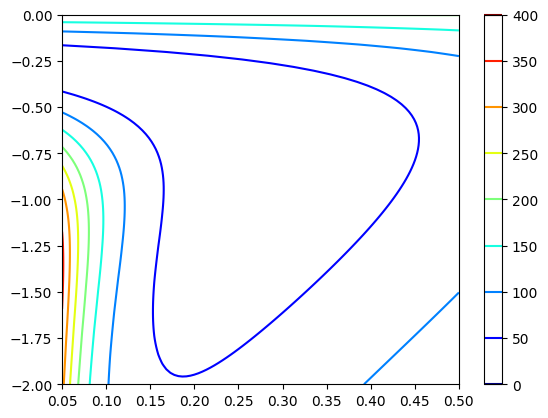

In [43]:
plt.contour(omega_m,w0,chisquare_hubble,origin="lower")
plt.jet()
plt.colorbar()
plt.show()

In [44]:
print(min_chi_hubble)

19.184360647306143


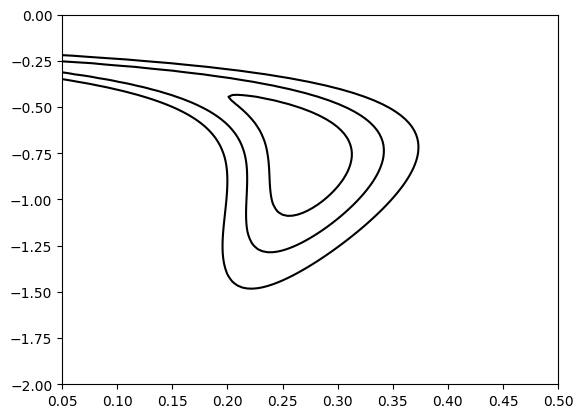

In [45]:
sigma=[0,2.30,6.17,11.8]
sigma_hubble=np.zeros((len(w0),len(w0)))
for i in range(len(w0)):
    for j in range(len(omega_m)):
        sigma_hubble[i,j]=(chisquare_hubble[i,j]-min_chi_hubble)
plt.contour(omega_m,w0,sigma_hubble,sigma,colors="black")

plt.show()

## Supernovae $\chi^2$

In [46]:
cov_matrix=np.zeros((N_sn,N_sn))
for i in range(N_sn):
    for j in range(N_sn):
        cov_matrix[i,j]=corr_matrix[i,j]*err_sn[i]*err_sn[j]

In [47]:
##Type Ia
w0=np.linspace(-2,0,100)
E_model=np.zeros(len(w0))
omega_m=np.linspace(0.05,0.5,len(w0))
chisquare_sn=np.zeros((len(w0),len(w0)))
#delta_chisquare_sn=np.zeros((len(w0),len(w0)))
#likelihood_sn=np.zeros((len(w0),len(w0)))
inv_cov=np.linalg.inv(cov_matrix)
min_chi_sn=9999999999
for k in range(len(w0)):
    w_0=w0[k]
    for t in range(len(omega_m)):
        chisquare_ij=0
        omegam=omega_m[t]
        for i in range(N_sn):
            E_model_i=Model(w_0,omegam,z_sn[i],wa)
            for j in range(N_sn):
                E_model_j=Model(w_0,omegam,z_sn[j],wa)
                chisquare_ij+=(1/E_sn[i]-1/E_model_i)*inv_cov[i,j]*(1/E_sn[j]-1/E_model_j)
        chisquare_sn[k,t]=chisquare_ij
        if min_chi_sn>chisquare_sn[k,t]:
            min_chi_sn=chisquare_sn[k,t]

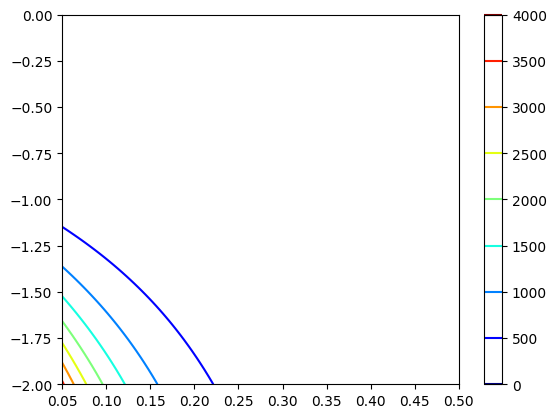

In [48]:
plt.contour(omega_m,w0,chisquare_sn,origin="lower")
plt.jet()
plt.colorbar()
plt.show()

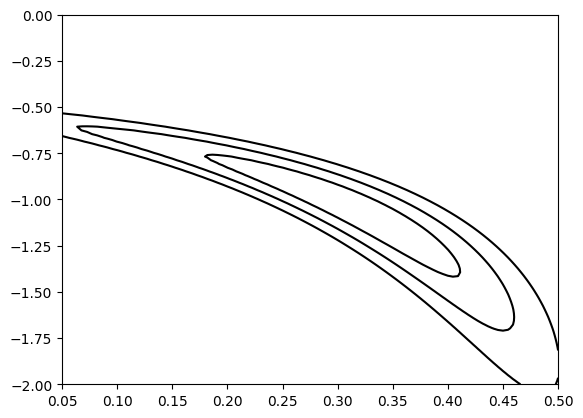

In [49]:
sigma=[0,2.30,6.17,11.8]
sigma_sn=np.zeros((len(w0),len(w0)))
for i in range(len(w0)):
    for j in range(len(omega_m)):
        sigma_sn[i,j]=(chisquare_sn[i,j]-min_chi_sn)
plt.contour(omega_m,w0,sigma_sn,sigma,colors="black")
plt.show()

## Joint $\chi^2$

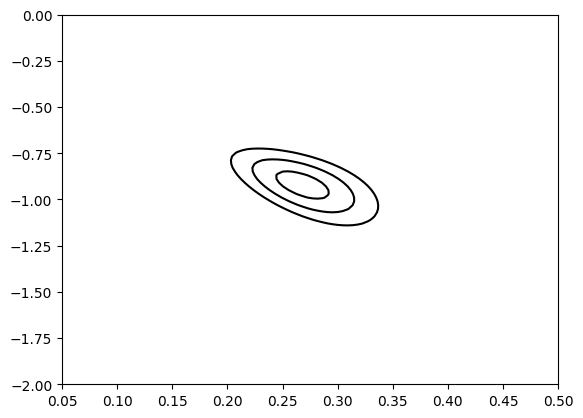

In [50]:
chi_square_joint=chisquare_hubble+chisquare_sn
sigma=[0,2.30,6.17,11.8]
sigma_joint=np.zeros((len(w0),len(w0)))
for i in range(len(w0)):
    for j in range(len(omega_m)):
        sigma_joint[i,j]=(chi_square_joint[i,j]-min_chi_hubble-min_chi_sn)
plt.contour(omega_m,w0,sigma_joint,sigma,colors="black")

plt.show()

# Marginalization

## Hubble

In [51]:
n=1

threshold_nsigma = sigma[n]

# Initialize lists to store parameter values for the nσ confidence level
params_nsigma = []

# Iterate through the sigma_joint array and check if the values meet the nσ threshold
for i in range(len(w0)):
    for j in range(len(omega_m)):
        delta_chi_squared = sigma_hubble[i, j]
        if delta_chi_squared <= threshold_1sigma:
            params_1sigma.append((omega_m[j], w0[i]))


max_omega_m_1sigma = max(params_1sigma, key=lambda x: x[0])
min_omega_m_1sigma = min(params_1sigma, key=lambda x: x[0])
max_w0_1sigma = max(params_1sigma, key=lambda x: x[1])
min_w0_1sigma = min(params_1sigma, key=lambda x: x[1])

# Calculate average values for nσ
avg_omega_m_1sigma_hubble = sum([x[0] for x in params_1sigma]) / len(params_1sigma)
avg_w0_1sigma_hubble = sum([x[1] for x in params_1sigma]) / len(params_1sigma)

# Sort the parameter values in params_1sigma by omega_m and w0 separately for median calculation
params_1sigma_sorted_by_omega_m = sorted(params_1sigma, key=lambda x: x[0])
params_1sigma_sorted_by_w0 = sorted(params_1sigma, key=lambda x: x[1])

# Calculate the median values for nσ
median_omega_m_1sigma = params_1sigma_sorted_by_omega_m[len(params_1sigma_sorted_by_omega_m) // 2]
median_w0_1sigma = params_1sigma_sorted_by_w0[len(params_1sigma_sorted_by_w0) // 2]

# Print the results for nσ
print("Hubble: Average Omega_m (1σ):", avg_omega_m_1sigma_hubble)
print("Hubble: Average w0 (1σ):", avg_w0_1sigma_hubble)
print("Hubble: Deviation from the mean Omega (1σ):", abs(avg_omega_m_1sigma-max_omega_m_1sigma[0]))
print("Hubble: Deviation from the mean Omega (1σ):", abs(avg_omega_m_1sigma-min_omega_m_1sigma[0]))
print("Hubble: Deviation from the mean w0 (1σ):", abs(avg_w0_1sigma-max_w0_1sigma[1]))
print("Hubble: Deviation from the mean w0 (1σ):", abs(avg_w0_1sigma-min_w0_1sigma[1]))


Hubble: Average Omega_m (1σ): 0.2646802049724803
Hubble: Average w0 (1σ): -0.7656101727082985
Hubble: Deviation from the mean Omega (1σ): 0.040445269016697594
Hubble: Deviation from the mean Omega (1σ): 0.06410018552875696
Hubble: Deviation from the mean w0 (1σ): 0.4786641929499067
Hubble: Deviation from the mean w0 (1σ): 0.14759843331271938


## Supernovae

In [52]:
n=1

threshold_nsigma = sigma[n]

# Initialize lists to store parameter values for the nσ confidence level
params_nsigma = []

# Iterate through the sigma_joint array and check if the values meet the nσ threshold
for i in range(len(w0)):
    for j in range(len(omega_m)):
        delta_chi_squared = sigma_sn[i, j]
        if delta_chi_squared <= threshold_1sigma:
            params_1sigma.append((omega_m[j], w0[i]))


max_omega_m_1sigma = max(params_1sigma, key=lambda x: x[0])
min_omega_m_1sigma = min(params_1sigma, key=lambda x: x[0])
max_w0_1sigma = max(params_1sigma, key=lambda x: x[1])
min_w0_1sigma = min(params_1sigma, key=lambda x: x[1])

# Calculate average values for nσ
avg_omega_m_1sigma_sn = sum([x[0] for x in params_1sigma]) / len(params_1sigma)
avg_w0_1sigma_sn = sum([x[1] for x in params_1sigma]) / len(params_1sigma)

# Sort the parameter values in params_1sigma by omega_m and w0 separately for median calculation
params_1sigma_sorted_by_omega_m = sorted(params_1sigma, key=lambda x: x[0])
params_1sigma_sorted_by_w0 = sorted(params_1sigma, key=lambda x: x[1])

# Calculate the median values for nσ
median_omega_m_1sigma = params_1sigma_sorted_by_omega_m[len(params_1sigma_sorted_by_omega_m) // 2]
median_w0_1sigma = params_1sigma_sorted_by_w0[len(params_1sigma_sorted_by_w0) // 2]

# Print the results for nσ
print("Supernovae: Average Omega_m (1σ):", avg_omega_m_1sigma_sn)
print("Supernovae: Average w0 (1σ):", avg_w0_1sigma_sn)
print("Supernovae: Deviation from the mean Omega (1σ):", abs(avg_omega_m_1sigma-max_omega_m_1sigma[0]))
print("Supernovae: Deviation from the mean Omega (1σ):", abs(avg_omega_m_1sigma-min_omega_m_1sigma[0]))
print("Supernovae: Deviation from the mean w0 (1σ):", abs(avg_w0_1sigma-max_w0_1sigma[1]))
print("Supernovae: Deviation from the mean w0 (1σ):", abs(avg_w0_1sigma-min_w0_1sigma[1]))


Supernovae: Average Omega_m (1σ): 0.2857900943396224
Supernovae: Average w0 (1σ): -0.8962264150943391
Supernovae: Deviation from the mean Omega (1σ): 0.14044526901669757
Supernovae: Deviation from the mean Omega (1σ): 0.08682745825602967
Supernovae: Deviation from the mean w0 (1σ): 0.4786641929499067
Supernovae: Deviation from the mean w0 (1σ): 0.491032776747063


## Joint

In [53]:
n=1

threshold_nsigma = sigma[n]

# Initialize lists to store parameter values for the nσ confidence level
params_nsigma = []

# Iterate through the sigma_joint array and check if the values meet the nσ threshold
for i in range(len(w0)):
    for j in range(len(omega_m)):
        delta_chi_squared = sigma_joint[i, j]
        if delta_chi_squared <= threshold_1sigma:
            params_1sigma.append((omega_m[j], w0[i]))


max_omega_m_1sigma = max(params_1sigma, key=lambda x: x[0])
min_omega_m_1sigma = min(params_1sigma, key=lambda x: x[0])
max_w0_1sigma = max(params_1sigma, key=lambda x: x[1])
min_w0_1sigma = min(params_1sigma, key=lambda x: x[1])

# Calculate average values for nσ
avg_omega_m_1sigma_joint = sum([x[0] for x in params_1sigma]) / len(params_1sigma)
avg_w0_1sigma_joint = sum([x[1] for x in params_1sigma]) / len(params_1sigma)

# Sort the parameter values in params_1sigma by omega_m and w0 separately for median calculation
params_1sigma_sorted_by_omega_m = sorted(params_1sigma, key=lambda x: x[0])
params_1sigma_sorted_by_w0 = sorted(params_1sigma, key=lambda x: x[1])

# Calculate the median values for nσ
median_omega_m_1sigma = params_1sigma_sorted_by_omega_m[len(params_1sigma_sorted_by_omega_m) // 2]
median_w0_1sigma = params_1sigma_sorted_by_w0[len(params_1sigma_sorted_by_w0) // 2]

# Print the results for nσ
print("Joint: Average Omega_m (1σ):", avg_omega_m_1sigma_joint)
print("Joint: Average w0 (1σ):", avg_w0_1sigma_joint)
print("Joint: Deviation from the mean Omega (1σ):", abs(avg_omega_m_1sigma-max_omega_m_1sigma[0]))
print("Joint: Deviation from the mean Omega (1σ):", abs(avg_omega_m_1sigma-min_omega_m_1sigma[0]))
print("Joint: Deviation from the mean w0 (1σ):", abs(avg_w0_1sigma-max_w0_1sigma[1]))
print("Joint: Deviation from the mean w0 (1σ):", abs(avg_w0_1sigma-min_w0_1sigma[1]))


Joint: Average Omega_m (1σ): 0.2848535522448563
Joint: Average w0 (1σ): -0.8976948976948971
Joint: Deviation from the mean Omega (1σ): 0.14044526901669757
Joint: Deviation from the mean Omega (1σ): 0.08682745825602967
Joint: Deviation from the mean w0 (1σ): 0.4786641929499067
Joint: Deviation from the mean w0 (1σ): 0.491032776747063


## $\chi^2$

Text(0, 0.5, '$w_0$')

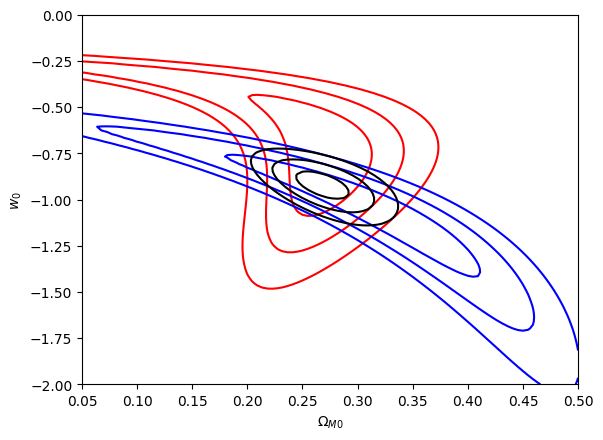

In [54]:
plt.contour(omega_m,w0,sigma_hubble,sigma,colors="red")
plt.contour(omega_m,w0,sigma_sn,sigma,colors="blue")
plt.contour(omega_m,w0,sigma_joint,sigma,colors="black")
plt.xlabel(r"$\Omega_{M0}$")
plt.ylabel(r"$w_0$")

# Likelihood with $\Omega_m=0.27$

## Hubble

In [55]:
##Hubble
w0=np.linspace(-2,0,100)
omegam=avg_omega_m_1sigma_hubble
E_model=np.zeros(len(w0))
chisquare_hubblew0=np.zeros(len(w0))
min_chi_hubble=9999999999

for j in range(len(w0)):
    w_0=w0[j]
    Gamma=0
    B=0
    A=0
    for i in range(N_hubble):
        E_model=Model(w_0,omegam,z_hubble[i],wa)
        Gamma+=(H[i]/err_H[i])**2
        B+=E_model*H[i]/err_H[i]**2
        A+=E_model**2/err_H[i]**2
    chis=Gamma-B**2/A+np.log(A)-2*np.log(1+mt.erf(B/np.sqrt(2*A)))
    chisquare_hubblew0[j]=chis
    if min_chi_hubble>chisquare_hubblew0[j]:
        min_chi_hubble=chisquare_hubblew0[j]

## Supernovae

In [56]:
##Type Ia
w0=np.linspace(-2,0,100)
E_model=np.zeros(len(w0))
omegam=avg_omega_m_1sigma_sn
chisquare_snw0=np.zeros(len(w0))
#delta_chisquare_sn=np.zeros((len(w0),len(w0)))
#likelihood_sn=np.zeros((len(w0),len(w0)))
inv_cov=np.linalg.inv(cov_matrix)
min_chi_sn=9999999999
for k in range(len(w0)):
    w_0=w0[k]
    chisquare_ij=0
    for i in range(N_sn):
        E_model_i=Model(w_0,omegam,z_sn[i],wa)
        for j in range(N_sn):
            E_model_j=Model(w_0,omegam,z_sn[j],wa)
            chisquare_ij+=(1/E_sn[i]-1/E_model_i)*inv_cov[i,j]*(1/E_sn[j]-1/E_model_j)
    chisquare_snw0[k]=chisquare_ij
    if min_chi_sn>chisquare_snw0[k]:
        min_chi_sn=chisquare_snw0[k]

In [57]:
def min_max_scaling(data):
    min_val = min(data)
    max_val = max(data)
    
    scaled_data = [(x - min_val) / (max_val - min_val) for x in data]
    
    return scaled_data

In [58]:
chi_square_jointw0=chisquare_hubblew0+chisquare_snw0

## $\mathcal{L}$ for $\Omega_m=0.27$

In [74]:
lik_hw0=np.exp(-chisquare_hubblew0/2)
lik_snw0=(1/(mt.sqrt(np.linalg.det(cov_matrix))*(2*mt.pi)**(N_sn/2)))*np.array(np.exp(-chisquare_snw0/2))
lik_jw0=list(map(operator.mul, lik_hw0, lik_snw0))

Text(0, 0.5, 'Likelihood')

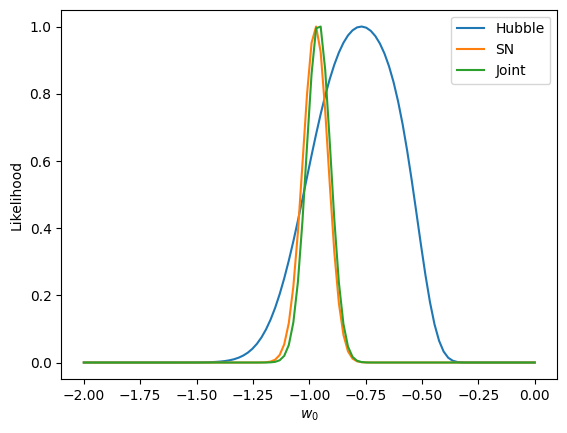

In [75]:
plt.plot(w0,lik_hw0)
plt.plot(w0,lik_snw0)
plt.plot(w0,lik_jw0)
plt.legend(["Hubble","SN","Joint"])
plt.xlabel(r"$w_0$")
plt.ylabel(r"Likelihood")

In [76]:
lik_hw0_scale=min_max_scaling(np.exp(-chisquare_hubblew0/2))
lik_snw0_scale=min_max_scaling((1/(abs(mt.sqrt(np.linalg.det(cov_matrix)))*(2*mt.pi)**(N_sn/2)))*np.array(np.exp(-chisquare_snw0/2)))
lik_jw0_scale=min_max_scaling(list(map(operator.mul, lik_hw0, lik_snw0)))

Text(0, 0.5, 'Likelihood')

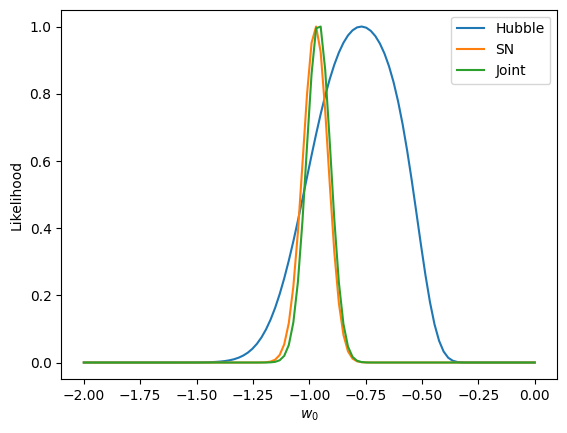

In [77]:
plt.plot(w0,lik_hw0_scale)
plt.plot(w0,lik_snw0_scale)
plt.plot(w0,lik_jw0_scale)
plt.legend(["Hubble","SN","Joint"])
plt.xlabel(r"$w_0$")
plt.ylabel(r"Likelihood")

# Likelihood with $w_0=-0.92$

## Hubble

In [63]:
##Hubble
w_0=avg_w0_1sigma_hubble
omega_m=np.linspace(0.05,0.5,len(w0))
E_model=np.zeros(len(w0))
chisquare_hubbleOm=np.zeros(len(w0))
min_chi_hubble=9999999999


for k in range(len(omega_m)):
    Gamma=0
    B=0
    A=0
    omegam=omega_m[k]
    for i in range(N_hubble):
        E_model=Model(w_0,omegam,z_hubble[i],wa)
        Gamma+=(H[i]/err_H[i])**2
        B+=E_model*H[i]/err_H[i]**2
        A+=E_model**2/err_H[i]**2
    chis=Gamma-B**2/A+np.log(A)-2*np.log(1+mt.erf(B/np.sqrt(2*A)))
    chisquare_hubbleOm[k]=chis
    if min_chi_hubble>chisquare_hubbleOm[k]:
        min_chi_hubble=chisquare_hubbleOm[k]

## Supernovae

In [64]:
##Type Ia
w_0=avg_w0_1sigma_sn
E_model=np.zeros(len(w0))
omega_m=np.linspace(0.05,0.5,len(w0))
chisquare_snOm=np.zeros(len(w0))
#delta_chisquare_sn=np.zeros((len(w0),len(w0)))
#likelihood_sn=np.zeros((len(w0),len(w0)))
inv_cov=np.linalg.inv(cov_matrix)
min_chi_sn=9999999999
for t in range(len(omega_m)):
    chisquare_ij=0
    omegam=omega_m[t]
    for i in range(N_sn):
        E_model_i=Model(w_0,omegam,z_sn[i],wa)
        for j in range(N_sn):
            E_model_j=Model(w_0,omegam,z_sn[j],wa)
            chisquare_ij+=(1/E_sn[i]-1/E_model_i)*inv_cov[i,j]*(1/E_sn[j]-1/E_model_j)
    chisquare_snOm[t]=chisquare_ij
    if min_chi_sn>chisquare_snOm[t]:
        min_chi_sn=chisquare_snOm[t]

## $\mathcal{L}$ for $w_0=-0.92$

In [78]:
lik_hOm=min_max_scaling(np.exp(-1/2*chisquare_hubbleOm))
lik_snOm=min_max_scaling((1/(abs(mt.sqrt(np.linalg.det(cov_matrix)))*(2*mt.pi)**(N_sn/2)))*np.exp(-chisquare_snOm/2))
lik_jOm=min_max_scaling(list(map(operator.mul, lik_hOm, lik_snOm)))

Text(0, 0.5, 'Likelihood')

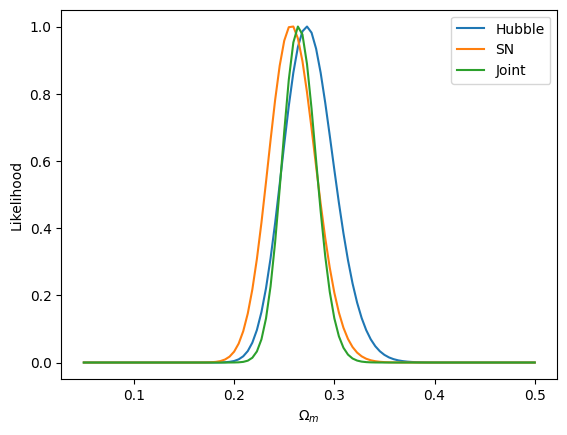

In [79]:
plt.plot(omega_m,lik_hOm)
plt.plot(omega_m,lik_snOm)
plt.plot(omega_m,lik_jOm)
plt.legend(["Hubble","SN","Joint"])
plt.xlabel(r"$\Omega_m$")
plt.ylabel(r"Likelihood")

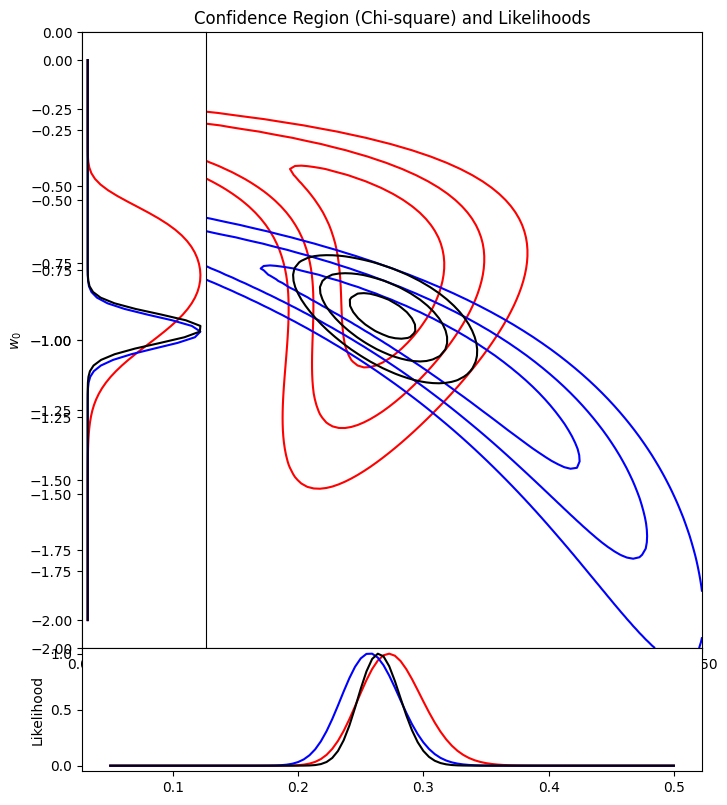

In [81]:

# Create the figure and axis
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the confidence region
ax.contour(omega_m,w0,sigma_hubble,sigma,colors="blue")
ax.contour(omega_m,w0,sigma_sn,sigma,colors="red")
ax.contour(omega_m,w0,sigma_joint,sigma,colors="black")


# Plot the likelihood for b on the left
ax2 = ax.inset_axes([0, 0, 0.2, 1], transform=ax.transAxes)
ax2.plot(lik_hw0_scale, w0, color='blue')
ax2.plot(lik_snw0_scale, w0, color='red')
ax2.plot(lik_jw0_scale, w0, color='black')
ax2.set_xlabel('Likelihood')

# Plot the likelihood for a below
ax3 = ax.inset_axes([0, -0.2, 1, 0.2], transform=ax.transAxes)
ax3.plot(omega_m, lik_hOm, color='blue')
ax3.plot(omega_m, lik_snOm, color='red')
ax3.plot(omega_m, lik_jOm, color='black')
ax3.set_ylabel('Likelihood')

# Set labels and title
ax.set_xlabel(r"$\Omega_{M0}$")
ax.set_ylabel(r"$w_0$")
ax.set_title('Confidence Region (Chi-square) and Likelihoods')

plt.show()
